### Ejercicio 1.
Escribir un programa que cree un número de threads indicado por el primer argumento, de forma que:
- Cada thread se le asignará un identificador 0,1,2…  que imprimirá por la salida estándar y usará para hacer un sleep(3) de los mismos segundos.
- El thread principal esperará a que terminen todos los threads, mostrando el identificador del thread que termina.


In [ ]:
#include <stdio.h>
#include <pthread.h>
#include <unistd.h>
#include <stdlib.h>

// Definicion de la estructura para pasar argumentos a los threads.
typedef struct _thread_info_t{ // typedef sirve para definir un nuevo tipo de dato.
    int num_thread; // Numero de thread.
    pthread_t id; // Identificador del thread a nivel de POSIX.
} thread_info;

void* haz_thread(void* _info) {
    thread_info_t* info = (thread_info_t*) _info; // casteamos el puntero void a thread_info_t.

    printf("Thread %i, sleeping...\n", info->num_thread);
    sleep(info->num_thread); //indica el numero de thread

    return NULL;
}

int main(int argc, char *argv[]) {
    // Primer argumento es el numero de threads.
    int nt = atoi(argv[1]);

    // reservamos memoria para los threads "malloc(nt * sizeof(thread_info_t))".
    // Creamos un array de estructuras thread_info_t.
    thread_info_t * pool = (thread_info_t*) malloc(nt * sizeof(thread_info_t));

    // Creamos un array de threads.
    for (int i = 0; i < nt; i++) {
        // Inicializamos la estructura de cada thread.
        pool[i].num_thread = i;

        pthread_create(&pool[i].id,         // Identificador del thread.
                        NULL,                  // Atributos por defecto. 0 == NULL.
                        haz_thread,         // Funcion de inicio del thread.
                        (void *) &pool[i]); // Argumentos para la funcion del thread.
    }

    for (int i = 0; i < nt; i++) {
        // Sincronizamos los threads.
        pthread_join(pool[i].id,
                    NULL);
        printf("Thread %i termino\n", pool[i].num_thread);
    }

    free(pool); // Liberamos la memoria reservada.

    return 0;
}

### Ejercicio 3
Escribir un programa que realice la suma paralela de los N primeros números naturales. Los argumentos del programa fijarán:
- Primer argumento, el número de threads (Nt).
- Segundo argumento, el tamaño de bloque (Tb) que determina cuántos números sumará cada thread.

Cada thread se le asignará un identificador (i = 0,1,2…) y sumará los enteros en el rango [Tb⋅i - (i+1)⋅Tb - 1] que agregará en una variable compartida, suma. El thread principal sincronizará todos los threads y mostrará la suma.


In [ ]:
#include <stdio.h>
#include <pthread.h>
#include <unistd.h>
#include <stdlib.h>

// Definicion de la estructura para pasar argumentos a los threads.
typedef struct _thread_info_t{ // typedef sirve para definir un nuevo tipo de dato.
    int num_thread; // Numero de thread.
    int tb; // Tamaño de bloque.

    pthread_t id; // Identificador del thread a nivel de POSIX.
} thread_info;

typedef struct _suma_p_t{
    pthread_mutex_t mutex; // Mutex para proteger la variable compartida.
    int suma; // Variable compartida para la suma.
} suma_p_t;

// Variable global para la suma paralela.
suma_p_t suma = {PTHREAD_MUTEX_INITIALIZER, 0}; // Inicializamos el mutex y la suma a 0.

void* haz_thread(void* _info) {
    thread_info_t* info = (thread_info_t*) _info; // casteamos el puntero void a thread_info_t.
    
    int suma_parcial = 0;
    int ini = info->tb * info->num_thread;
    int fin = info->tb * (info->num_thread +1);

    printf("[%i] Sumando %i - %i\n", info->num_thread, ini, fin);
    for (int i = ini; i < fin; i++) {
        suma_parcial += i;
    }


    //  ESTO ES REGION CRITICA!!!!!!!!!!
    // Sumamos la suma parcial a la variable compartida.
    suma.suma += suma_parcial;
    // SE ACABA REGION CRITICA!!!!!!!!!!


    sleep(info->num_thread); //indica el numero de thread

    return NULL;
}

int main(int argc, char *argv[]) {
    // Primer argumento es el numero de threads.
    int nt = atoi(argv[1]);
    // Segundo argumento es el tamaño de bloque.
    int tb = atoi(argv[2]);

    // reservamos memoria para los threads "malloc(nt * sizeof(thread_info_t))".
    // Creamos un array de estructuras thread_info_t.
    thread_info_t * pool = (thread_info_t*) malloc(nt * sizeof(thread_info_t));

    // Creamos un array de threads.
    for (int i = 0; i < nt; i++) {
        // Inicializamos la estructura de cada thread.
        pool[i].num_thread = i;

        pthread_create(&pool[i].id,         // Identificador del thread.
                        NULL,               // Atributos por defecto. 0 == NULL.
                        haz_thread,         // Funcion de inicio del thread.
                        (void *) &pool[i]); // Argumentos para la funcion del thread.
    }

    for (int i = 0; i < nt; i++) {
        // Sincronizamos los threads.
        pthread_join(pool[i].id,
                    NULL);
        printf("Thread %i termino\n", pool[i].num_thread);
    }

    // esto es porque la suma de los n primeros numeros naturales es n*(n+1)/2 (suma de Gauss)
    int n = (nt * tb) - 1;
    printf("Suma total: %i / %i\n", suma.suma, (n *(n +1) /2 ));

    free(pool); // Liberamos la memoria reservada.

    return 0;
}

### Ejercicio 6
Escribir un programa que cree L lectores (primer argumento) y E escritores (segundo argumento), de forma que:
- Los threads Lector imprimirán por pantalla un entero compartido y esperarán 0.1s con la llamada usleep(3). Este acceso lo repetirán 5 veces.
- Los threads Escritor incrementarán en 1 la variable y esperarán 0.25s. Este acceso lo repetirán 3 veces.
- El thread principal arrancará primero los escritores.

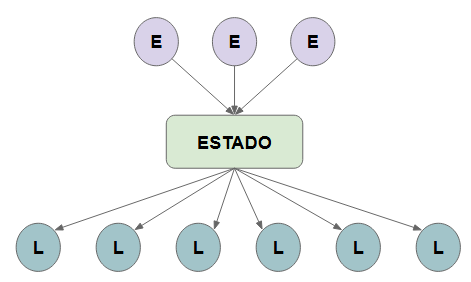

observacion: Posix prioriza los lectores a los escritores.

In [ ]:
#include <stdio.h>
#include <pthread.h>
#include <unistd.h>
#include <stdlib.h>

// Definicion de la estructura para pasar argumentos a los threads.
typedef struct _thread_info_t{ // typedef sirve para definir un nuevo tipo de dato.
    int         num_thread; // Numero de thread.
    pthread_t   id;         // Identificador del thread a nivel de POSIX.
} thread_info_t;

typedef struct _shared_i_t{
    pthread_rwlock_t mutex; // Mutex para proteger la variable compartida.
    int             valor; // Variable compartida para la suma.
} shared_i_t;

// Variable global para la suma paralela.
shared_i_t numero = {PTHREAD_RWLOCK_INITIALIZER, 0}; // Inicializamos el mutex y la suma a 0.

#define NUM_LECTURAS 5
#define NUM_ESCRITURAS 3

void* lector(void* _info) {
    thread_info_t* info = (thread_info_t*) _info; // casteamos el puntero void a thread_info_t.

    for (int i = 0; i < NUM_LECTURAS; i++) {
        pthread_rwlock_rdlock(&numero.mutex); // Bloqueamos para lectura.

        // Simulamos un trabajo de lectura.
        printf("L[%i] %i\n", info->num_thread, numero.valor);
        usleep(100000); // Simulamos tiempo de lectura.

        pthread_rwlock_unlock(&numero.mutex); // Desbloqueamos.
    }

    return NULL;
}
void* escritor(void* _info) { 
    thread_info_t* info = (thread_info_t*) _info; // casteamos el puntero void a thread_info_t.

    for (int i = 0; i < NUM_ESCRITURAS; i++) {
        pthread_rwlock_wrdlock(&numero.mutex); // Bloqueamos para escritura.

        // Simulamos un trabajo de escritura.
        printf("E[%i] %i\n", info->num_thread, numero.valor);
        usleep(250000); // Simulamos tiempo de escritura.

        pthread_rwlock_unlock(&numero.mutex); // Desbloqueamos.
    }
    
    return NULL;
}

int main(int argc, char *argv[]) {
    // Primer argumento es el numero lectores.
    int le = atoi(argv[1]);
    // Segundo argumento es el tamaño de escritores.
    int es = atoi(argv[2]);

    // reservamos memoria para los threads "malloc(nt * sizeof(thread_info_t))".
    // Creamos un array de estructuras thread_info_t.
    thread_info_t * pool = (thread_info_t*) 
        malloc((le + es) * sizeof(thread_info_t));

    // Creamos los threads escritores.
    for (int i = 0; i < es; i++) {
        // Inicializamos la estructura de cada thread.
        pool[i].num_thread = i;

        pthread_create(&pool[i].id,         // Identificador del thread.
                        NULL,               // Atributos por defecto. 0 == NULL.
                        escritor,           // Funcion de inicio del thread.
                        (void *) &pool[i]); // Argumentos para la funcion del thread.
    }

    // Creamos los threads lectores.
    for (int i = es; i < es + le; i++) {
        // Inicializamos la estructura de cada thread.
        pool[i].num_thread = i - es;

        pthread_create(&pool[i].id,         // Identificador del thread.
                        NULL,               // Atributos por defecto. 0 == NULL.
                        lector,           // Funcion de inicio del thread.
                        (void *) &pool[i]); // Argumentos para la funcion del thread.
    }

    for (int i = 0; i < (es + le); i++) {
        // Sincronizamos los threads.
        pthread_join(pool[i].id,
                    NULL);
        printf("Thread %i termino\n", pool[i].num_thread);
    }

    free(pool); // Liberamos la memoria reservada.

    return 0;
}

In [ ]:
#include <stdio.h>
#include <pthread.h>
#include <unistd.h>
#include <stdlib.h>

#define BUFFER_SIZE 10
#define P_ELEMENTS 5

// Definicion de la estructura para pasar argumentos a los threads.
typedef struct _thread_info_t{ // typedef sirve para definir un nuevo tipo de dato.
    int         num_thread; // Numero de thread.
    pthread_t   id;         // Identificador del thread a nivel de POSIX.
} thread_info_t;

typedef struct _buffer_t{
    pthread_mutex_t mutex; // Mutex para proteger el buffer.

    pthread_cond_t  produce; // Condicion para productores.
    pthread_cond_t  consume; // Condicion para consumidores.

    int in; // Indice de escritura.
    int out; // Indice de lectura.
    
    int elements; // Numero de elementos en el buffer.

    char data[BUFFER_SIZE]; // buffer de datos circular.
} buffer_t;

// Variable global para la suma paralela.
buffer_t buffer =   {PTHREAD_MUTEX_INITIALIZER, // Mutex para proteger el buffer.
                    PTHREAD_COND_INITIALIZER,   // Condicion para productores.
                    PTHREAD_COND_INITIALIZER,   // Condicion para consumidores.
                    0,                          // Indice de escritura.
                    0,                          // Indice de lectura. 
                    0};                         // Numero de elementos en el buffer.


void* productor(void* _info) {
    thread_info_t* info = (thread_info_t*) _info; // casteamos el puntero void a thread_info_t.

    for (int i = 0; i < NUM_ELEMENTS; i++) {
        // ENTRADA A REGION CRITICA.
        pthread_mutex_lock(&buffer.mutex); // Bloqueamos el mutex del buffer.
        
        // Esperamos mientras el buffer esté lleno.
        while(buffer.elements >= BUFFER_SIZE) {
            pthread_cond_wait(&buffer.produce,  // Espera en la condicion de produccion.
                                &buffer.mutex); // Desbloquea el mutex mientras espera.
        }

        int item = 100*info->num+i;

        // MODIFICACION DEL BUFFER.
        buffer.data[buffer.in] = item; // Producimos un dato.
        buffer.in = (buffer.in + 1) % BUFFER_SIZE; // Actualizamos el indice de escritura.
        buffer.elements++; // Incrementamos el numero de elementos en el buffer.

        printf("P[%i] E:%i I:%i in:%i out:%i\n", 
                info->num_thread, buffer.elements, item, 
                buffer.in, buffer.out);

        // SALIDA DE REGION CRITICA.
        pthread_cond_signal(&buffer.consume); // Señalizamos a los consumidores que hay datos.
        pthread_mutex_unlock(&buffer.mutex); // Desbloqueamos el mutex del buffer.

        slep(1); // Simulamos tiempo de produccion.
    }
    return NULL;
}

void* consumidor(void* _info) {
    thread_info_t* info = (thread_info_t*) _info; // casteamos el puntero void a thread_info_t.

    whilre (1) {
        // ENTRADA A REGION CRITICA.
        pthread_mutex_lock(&buffer.mutex); // Bloqueamos el mutex del buffer.
        
        // Esperamos mientras el buffer esté lleno.
        while(buffer.elements <= 0) {
            pthread_cond_wait(&buffer.consume,  // Espera en la condicion de consumir.
                                &buffer.mutex); // Desbloquea el mutex mientras espera.
        }

        // MODIFICACION DEL BUFFER.
        int item = buffer.data[buffer.out]; // Consumimos un dato.
        buffer.out = (buffer.out + 1) % BUFFER_SIZE; // Actualizamos el indice de lectura.
        buffer.elements--; // Reducimos el numero de elementos en el buffer.

        printf("C[%i] E:%i I:%i in:%i out:%i\n", 
                info->num_thread, buffer.elements, item, 
                buffer.in, buffer.out);

        // SALIDA DE REGION CRITICA.
        pthread_cond_signal(&buffer.produce); // Señalizamos a los productores que se ha consumido un dato.
        pthread_mutex_unlock(&buffer.mutex); // Desbloqueamos el mutex del buffer.

        slep(1); // Simulamos tiempo de produccion.

    }

    return NULL;
}

int main(int argc, char *argv[]) {
    // Primer argumento es el numero de productores.
    int p = atoi(argv[1]);
    // Segundo argumento es el tamaño de consumidores.
    int c = atoi(argv[2]);

    // reservamos memoria para los threads "malloc(nt * sizeof(thread_info_t))".
    // Creamos un array de estructuras thread_info_t.
    thread_info_t * pool = (thread_info_t*) 
        malloc((p + c) * sizeof(thread_info_t));

    // Creamos los threads escritores.
    for (int i = 0; i < p; i++) {
        // Inicializamos la estructura de cada thread.
        pool[i].num_thread = i;

        pthread_create(&pool[i].id,         // Identificador del thread.
                        NULL,               // Atributos por defecto. 0 == NULL.
                        productor,          // Funcion de inicio del thread.
                        (void *) &pool[i]); // Argumentos para la funcion del thread.
    }

    // Creamos los threads lectores.
    for (int i = p; i < p + c; i++) {
        // Inicializamos la estructura de cada thread.
        pool[i].num_thread = i - p;

        pthread_create(&pool[i].id,         // Identificador del thread.
                        NULL,               // Atributos por defecto. 0 == NULL.
                        consumidor,           // Funcion de inicio del thread.
                        (void *) &pool[i]); // Argumentos para la funcion del thread.
    }

    for (int i = 0; i < (es + le); i++) {
        // Sincronizamos los threads.
        pthread_join(pool[i].id,
                    NULL);
        printf("Thread %i termino\n", pool[i].num_thread);
    }

    free(pool); // Liberamos la memoria reservada.

    return 0;
}